# Data augmentation techniques using Tensorflow

In [1]:
# Imports
import tensorflow as tf
import numpy as np
import matplotlib
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import os
import cv2 
import math

%matplotlib inline

## Collect image file paths

In [2]:
def get_image_paths():
    folder = './raw_images'
    files = os.listdir(folder)
    files.sort()
    files = ['{}/{}'.format(folder, f) for f in files]
    return files

In [3]:
X_img_file_paths = get_image_paths()
print(X_img_file_paths)

['./raw_images/01.png', './raw_images/02.png', './raw_images/03.png', './raw_images/04.png', './raw_images/05.png', './raw_images/06.png', './raw_images/07.png', './raw_images/08.png', './raw_images/09.png', './raw_images/10.png', './raw_images/11.png', './raw_images/12.png']


## Resize images to a common size

In [4]:
# Resizing
IMAGE_SIZE = 224

def tf_resize_images(X_img_file_paths):
    X_data = []
    tf.reset_default_graph()
    X = tf.placeholder(tf.float32, shape=[None, None, 3])
    tf_img = tf.image.resize_images(X, [IMAGE_SIZE, IMAGE_SIZE],
                             tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    
    with tf.Session() as session:
        session.run(tf.global_variables_initializer())
        
        for index, file_path in enumerate(X_img_file_paths):
            img = mpimg.imread(file_path)[:,:,:3]
            resized_img = session.run(tf_img, feed_dict={X: img})
            X_data.append(resized_img)
        
        X_data = np.array(X_data, dtype=np.float32)
        return X_data

In [5]:
X_imgs = tf_resize_images(X_img_file_paths)
print(X_imgs.shape)

(12, 224, 224, 3)


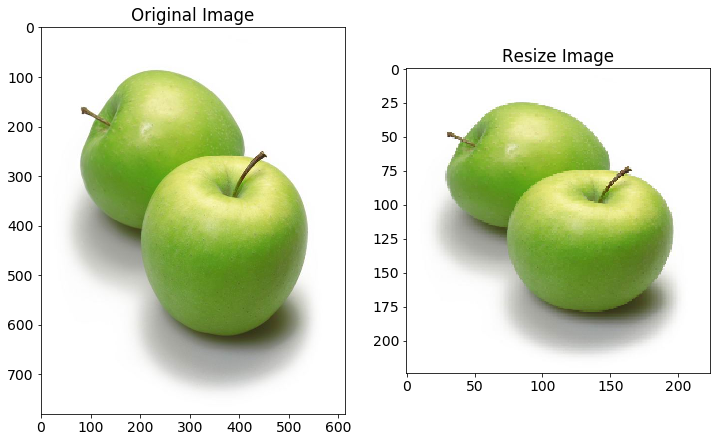

In [6]:
matplotlib.rcParams.update({'font.size': 14})

fig, ax = plt.subplots(figsize=(12, 12))
plt.subplot(121) # numrows, numcols, subplotnum
plt.imshow(mpimg.imread(X_img_file_paths[0]))
plt.title('Original Image')
plt.subplot(122)
plt.imshow(X_imgs[0])
plt.title('Resize Image')
plt.show()

## Display all images

In [7]:
def display_all_images(X_imgs, n_cols=4):
    n_rows = math.ceil(len(X_imgs) / n_cols)
    fig, ax = plt.subplots(figsize=(3*n_rows, 3*n_cols))
    for index, X_img in enumerate(X_imgs):
        plt.subplot(n_rows, n_cols, index+1)
        plt.imshow(X_img)
        plt.axis('off')
        
    plt.show()

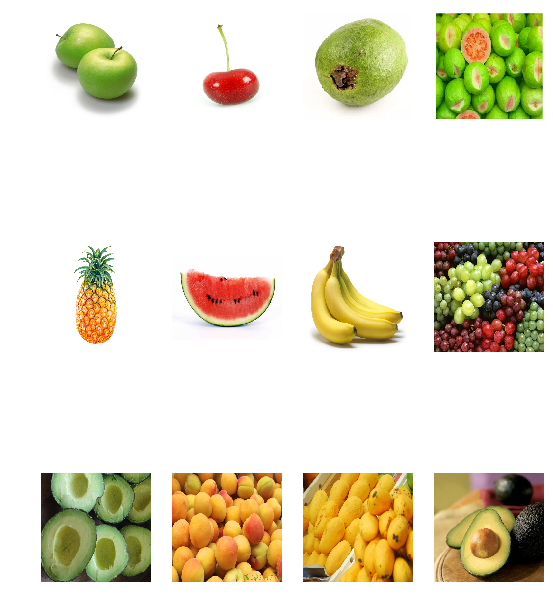

In [8]:
display_all_images(X_imgs)

## Image Augmentation Techniques

### 1) Scaling
Extracts crops from the input image tensor and bilinearly resizes them (possibly with aspect ratio change) to a common output size specified by 'crop_size'

In [9]:
def centrally_scale_images(X_imgs, scales):
    # Calculating tf.image.crop_and_resize() params
    boxes = np.zeros([len(scales), 4], dtype=np.float32)
    for index, scale in enumerate(scales):
        x1 = y1 = 0.5 - 0.5 * scale # To scale centrally
        x2 = y2 = 0.5 + 0.5 * scale
        boxes[index] = np.array([y1, x1, y2, x2], dtype=np.float32)

    box_ind = np.zeros(len(scales), dtype=np.int32)
    crop_size = np.array([IMAGE_SIZE, IMAGE_SIZE], dtype=np.int32)
    
    X_scale_data = []
    tf.reset_default_graph()
    X = tf.placeholder(tf.float32, shape=[1, IMAGE_SIZE, IMAGE_SIZE, 3])
    tf_img = tf.image.crop_and_resize(X, boxes, box_ind, crop_size)
    
    with tf.Session() as session:
        for img in X_imgs:
            batch_img = np.expand_dims(img, axis=0)
            scaled_imgs = session.run(tf_img, feed_dict={X: batch_img})
            X_scale_data.extend(scaled_imgs)
        
        X_scale_data = np.array(X_scale_data, dtype=np.float32)
        return X_scale_data

In [10]:
scales = [0.90, 0.75, 0.60]
scaled_imgs = centrally_scale_images(X_imgs, scales)
print(scaled_imgs.shape)

(36, 224, 224, 3)


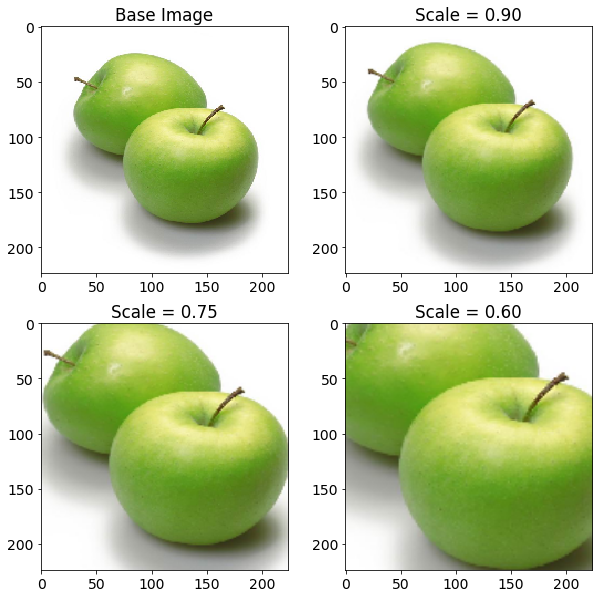

In [19]:
# Visualising the scaled images
index = np.random.randint(0, len(X_imgs))
fig, ax = plt.subplots(figsize=(10, 10))
n_scales = len(scales)

plt.subplot(221)
plt.imshow(X_imgs[index])
plt.title('Base Image')

plt.subplot(222)
plt.imshow(scaled_imgs[n_scales*index])
plt.title('Scale = 0.90')

plt.subplot(223)
plt.imshow(scaled_imgs[n_scales*index + 1])
plt.title('Scale = 0.75')

plt.subplot(224)
plt.imshow(scaled_imgs[n_scales*index + 2])
plt.title('Scale = 0.60')

plt.show()

### 2) Translation

In [12]:
def get_translate_params(index): 
    if index == 0: # Translate left 20%
        offset = np.array([0.0, 0.2], dtype=np.float32)
        size = np.array([IMAGE_SIZE, math.ceil(0.8 * IMAGE_SIZE)], dtype=np.float32)
        w_start = 0
        w_end = int(math.ceil(0.8 * IMAGE_SIZE))
        h_start = 0
        h_end = IMAGE_SIZE
    elif index == 1: # Translate right 20%
        offset = np.array([0.0, -0.2], dtype=np.float32)
        size = np.array([IMAGE_SIZE, math.ceil(0.8 * IMAGE_SIZE)], dtype=np.float32)
        w_start = int(math.floor(0.2 * IMAGE_SIZE))
        w_end = IMAGE_SIZE
        h_start = 0
        h_end = IMAGE_SIZE
    elif index == 2: # Translate top 20%
        offset = np.array([0.2, 0.0], dtype=np.float32)
        size = np.array([math.ceil(0.8 * IMAGE_SIZE), IMAGE_SIZE], dtype=np.float32)
        w_start = 0
        w_end = IMAGE_SIZE
        h_start = 0
        h_end = int(math.ceil(0.8 * IMAGE_SIZE))    
    elif index == 3: # Translate bottom 20%
        offset = np.array([-0.2, 0.0], dtype=np.float32)
        size = np.array([math.ceil(0.8 * IMAGE_SIZE), IMAGE_SIZE], dtype=np.float32)
        w_start = 0
        w_end = IMAGE_SIZE
        h_start = int(math.floor(0.2 * IMAGE_SIZE))
        h_end = IMAGE_SIZE 
        
    return offset, size, w_start, w_end, h_start, h_end

def translate_images(X_imgs):
    offsets = np.zeros([len(X_imgs), 2], dtype=np.float32)
    n_translations = 4
    X_translated_data = []

    tf.reset_default_graph()
    with tf.Session() as session:
        for i in range(n_translations):
            X_translated =\
                np.ones([len(X_imgs), IMAGE_SIZE, IMAGE_SIZE, 3], dtype=np.float32)
            base_offset, size, w_start, w_end, h_start, h_end = get_translate_params(i)
            offsets[:,:] = base_offset
            glimpses = tf.image.extract_glimpse(X_imgs, size, offsets)
            glimpses = session.run(glimpses)
            
            X_translated[:, h_start:h_end, w_start:w_end, :] = glimpses
            X_translated_data.extend(X_translated)
     
    X_translated_data = np.array(X_translated_data, dtype=np.float32)
    return X_translated_data

In [13]:
translated_imgs = translate_images(X_imgs)
print(translated_imgs.shape)

(48, 224, 224, 3)


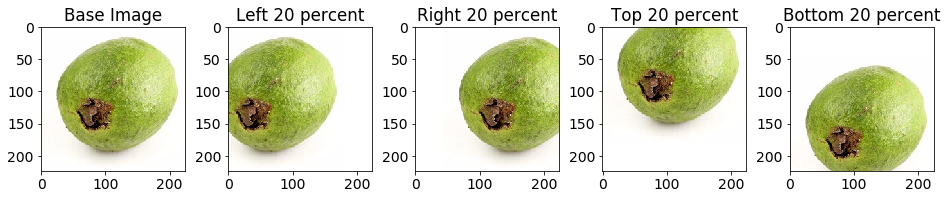

In [14]:
# Visualise the Translated images

gs = gridspec.GridSpec(1, 5)
gs.update(wspace = 0.30, hspace = 2)

fig, ax = plt.subplots(figsize = (16, 16))
plt.subplot(gs[0])
plt.imshow(X_imgs[2])
plt.title('Base Image')
plt.subplot(gs[1])
plt.imshow(translated_imgs[2])
plt.title('Left 20 percent')
plt.subplot(gs[2])
plt.imshow(translated_imgs[14])
plt.title('Right 20 percent')
plt.subplot(gs[3])
plt.imshow(translated_imgs[26])
plt.title('Top 20 percent')
plt.subplot(gs[4])
plt.imshow(translated_imgs[38])
plt.title('Bottom 20 percent')
plt.show()

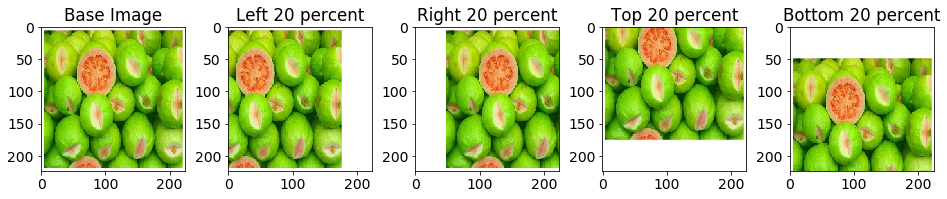

In [15]:
gs = gridspec.GridSpec(1, 5)
gs.update(wspace = 0.30, hspace = 2)

fig, ax = plt.subplots(figsize = (16, 16))
plt.subplot(gs[0])
plt.imshow(X_imgs[3])
plt.title('Base Image')
plt.subplot(gs[1])
plt.imshow(translated_imgs[3])
plt.title('Left 20 percent')
plt.subplot(gs[2])
plt.imshow(translated_imgs[15])
plt.title('Right 20 percent')
plt.subplot(gs[3])
plt.imshow(translated_imgs[27])
plt.title('Top 20 percent')
plt.subplot(gs[4])
plt.imshow(translated_imgs[39])
plt.title('Bottom 20 percent')
plt.show()

### 3) Rotation (90 degrees)

In [16]:
def rotate_images(X_imgs):
    X_rotate_data = []
    tf.reset_default_graph()

    X = tf.placeholder(tf.float32, shape=[IMAGE_SIZE, IMAGE_SIZE, 3])
    k = tf.placeholder(tf.int32)
    tf_img = tf.image.rot90(X, k) # Rotating images by 90, 180 and 270 degrees

    with tf.Session() as session:
        for img in X_imgs:
            for i in range(3):
                rotated_img = session.run(tf_img, feed_dict={X: img, k:i+1})
                X_rotate_data.append(rotated_img)
    
    X_rotate_data = np.array(X_rotate_data, dtype=np.float32)
    return X_rotate_data

In [17]:
rotated_imgs = rotate_images(X_imgs)
print(rotated_imgs.shape)

(36, 224, 224, 3)


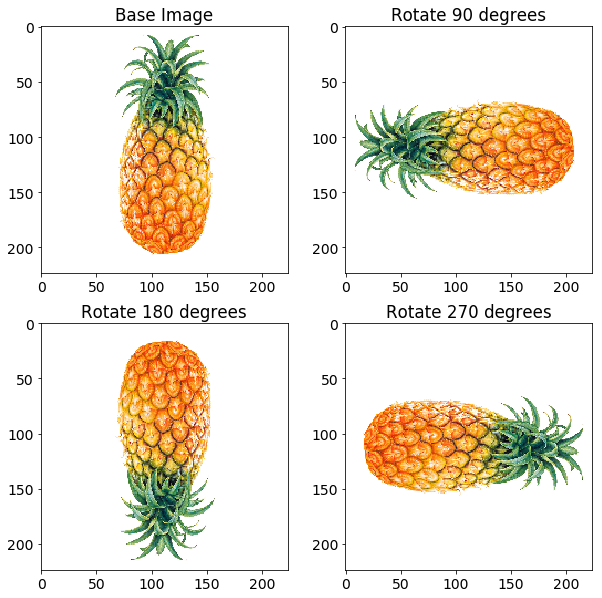

In [18]:
# Visualising rotated images

fig, ax = plt.subplots(figsize = (10, 10))
plt.subplot(2, 2, 1)
plt.imshow(X_imgs[4])
plt.title('Base Image')
plt.subplot(2, 2, 2)
plt.imshow(rotated_imgs[12])
plt.title('Rotate 90 degrees')
plt.subplot(2, 2, 3)
plt.imshow(rotated_imgs[13])
plt.title('Rotate 180 degrees')
plt.subplot(2, 2, 4)
plt.imshow(rotated_imgs[14])
plt.title('Rotate 270 degrees')
plt.show()

### 4) Rotation (at finer angles)